In [1]:
# import the necessary packages
import os
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2
from imutils.contours import sort_contours
#from yargy.tokenizer import MorphTokenizer
from yargy import rule, Parser, or_, and_, not_
from yargy.predicates import gram
from matplotlib import pyplot as plt

Trying to recognize text from image with pytesseract without image treatment

In [2]:
image = cv2.imread("DataForOCR/9.jpeg")
custom_oem_psm_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'

mrzText_to_string = pytesseract.image_to_string(image, lang='rus', config=custom_oem_psm_config)
print(mrzText_to_string)

о о
о о м
о А а о
о а
о а а а
о А в
ке
Е т ция у
девля ЕАтТРАНЦ
россии й
ах эияеномуФМСРОССИИ
ОТДЕЛОМУФМСЕ
В НОСВЕРДЛОВСКАОИЧох о
с
хе п оо ВКАТЕРИНЬХЕЕА
а а комРНЕГОРВКАТЕ
ВКИРОВСКОМЕ
т а з ЗЕ
а
о Ы г
а Ее ах Коливавааделения Е
С м ке
Е ИОН
о
Сеь Е
с о
о о е с Е Анчныйкод Ч
р а
И ы и ть
с И ее
о и и
о ое Се
а а а
О
з ы А а р о
Св ЕЕ Е Е п
я й О о
о
ЕЕ ЕТ в р
ЕЕ В РЕ ее з
т Е ЭМАКАЕВА
хх а
ИКобускркокоыое
аРОАИМЕЯАВ Е ИНН
ЕЕ х
а Е
их т и НЕЕ
За АВАТОЛЬЕВНА Е
т хе Ала ь Е
ба же пхЖЕНжмия
й а а ее
ф ь СрожАешияАЬЮ Е
Я т в со
А м У В х
Эа р а ВС
о
я т
гы а о а т
а т
й к ы г Ее а
ф Зы а кН ь т г
А д гы Е ти и ый
ай о ь
в в те
о
Я и
ы ы нь м
в ай я й ты а
м ай АомьНЕСНЫ
и м о
а а и
о ое о а
с о
и
А о о аа
о к с о
с о
о о ее
с м ое а



Bad recognition
<br>I will make some image cropping of passport part

In [3]:
from crop_morphology import crop_morphology
for i in range(10):
    if i != 4:
        crop_morphology(f'DataForOCR/{i}.jpeg', i)
    else:
        crop_morphology(f'DataForOCR/{i}.png', i)

cropped_img/0.png cropped
cropped_img/1.png cropped
cropped_img/2.png cropped
cropped_img/3.png cropped
cropped_img/4.png cropped
cropped_img/5.png cropped
cropped_img/6.png cropped
cropped_img/7.png cropped
cropped_img/8.png cropped
cropped_img/9.png cropped


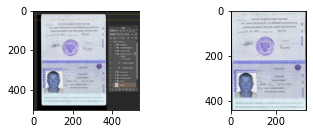

In [4]:
#check the result of cropping
images = ['DataForOCR/4.png', 'cropped_img/4.png']
columns = 2
for i, image in enumerate(images):
    image = cv2.imread(image)
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)


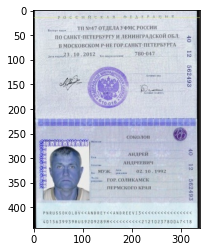

In [5]:
# load the input image and convert it to grayscale
image = cv2.imread("cropped_img/4.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape
plt.imshow(image)

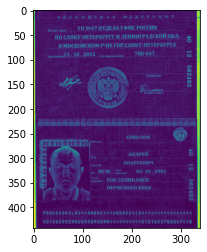

In [6]:
# initialize a rectangular and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 15))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
# smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background
gray = cv2.GaussianBlur(gray, (1, 1), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
plt.imshow(blackhat)

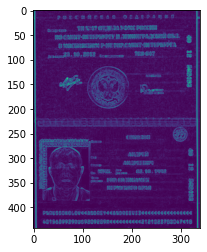

In [7]:
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad_horizontal = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad_horizontal = np.absolute(grad_horizontal)

(minVal, maxVal) = (np.min(grad_horizontal), np.max(grad_horizontal))
grad_horizontal = (grad_horizontal - minVal) / (maxVal - minVal)
grad_horizontal = (grad_horizontal * 255).astype("uint8")

grad_vertical = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
grad_vertical = np.absolute(grad_vertical)

(minVal, maxVal) = (np.min(grad_vertical), np.max(grad_vertical))
grad_vertical = (grad_vertical - minVal) / (maxVal - minVal)
grad_vertical = (grad_vertical * 255).astype("uint8")
#join vartical and horizontal
grad = cv2.addWeighted(grad_horizontal, 0.5, grad_vertical, 0.5, 0)
plt.imshow(grad)


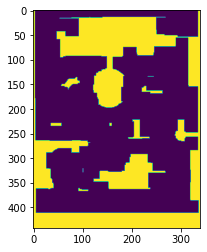

In [8]:
# apply a closing operation using the rectangular kernel to close
# gaps in between letters -- then apply Otsu's thresholding method
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# perform another closing operation, this time using the square
# kernel to close gaps between lines of the MRZ, then perform a
# series of erosions to break apart connected components
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
thresh = cv2.erode(thresh, None, iterations=2)
plt.imshow(thresh)


In [9]:
# find contours in the thresholded image and sort them from bottom
# to top (since the MRZ will always be at the bottom of the passport)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="bottom-to-top")[0]
# initialize the bounding box associated with the MRZ
mrzBox = None

In [10]:
union_table = []
union_table_test = []
# loop over the contours
for c in cnts:
    counter = 0

    # compute the bounding box of the contour and then derive the
    # how much of the image the bounding box occupies in terms of
    # both width and height
    (x, y, w, h) = cv2.boundingRect(c)
    percentWidth = w / float(W)
    percentHeight = h / float(H)
    #print(percentHeight, percentWidth)
    # image, then assume we have found the MRZ
    if x != 0 and y != 0 and w != 0 and h != 0 and percentWidth < 0.70:
        mrzBox = (x, y, w, h)
        (x, y, w, h) = mrzBox
        pX = int((x + w) * 0.03)
        pY = int((y + h) * 0.03)
        (x, y) = (x - pX, y - pY)
        (w, h) = (w + (pX * 2), h + (pY * 2))
        # extract the padded MRZ from the image

        mrz = image[y:y + h, x:x + w]
        custom_oem_psm_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'

        mrzText = pytesseract.image_to_data(mrz, lang='rus', config=custom_oem_psm_config, output_type=pytesseract.Output.DATAFRAME)
        mrzText_to_string = pytesseract.image_to_string(mrz, lang='rus', config=custom_oem_psm_config)
        mrzText_to_string = mrzText_to_string.replace(" ", "").replace("\n", "")
        if len(mrzText_to_string) > 4 and len(mrzText_to_string) < 20:

            union_table_test.append(mrzText_to_string)
        union_table.append(mrzText)

        #print(mrzText)		
        #virtical_img = cv2.rotate(mrz, cv2.ROTATE_90_COUNTERCLOCKWISE)
        #mrzText_vert = pytesseract.image_to_string(virtical_img, config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
        #mrzText_vert = mrzText_vert.replace(" ", "")
        #print(mrzText)

In [11]:
#join in one table and filter it
table = pd.concat(union_table)
table = table[(table['text'].notna()) & (table['text'].str.len() > 2) & (table['text'].str.len() < 17)]
table = table['text'].tolist()
print(table)
companies = []

['АНДРЕЙ', 'АНДРЕЕВИЧ', 'муж', 'говсоликамек', 'ПЕРМСКОГОкРАЯ', 'соколов']


In [12]:
#add yargy paresr to our script to detect only 
#full name from the text
counter = 0
for i in table:
        #print(i)
        if i.lower() in ('фамилия', 'имя', 'отчество'):
                companies.append(table[counter+1])
        counter += 1  
#set up some rules to filter name, patr, surname
COMPANY = rule(or_
                (and_
                (gram('Name'), 
                not_
                (gram('Abbr')),
                not_
                (gram('ADJS'))), 
                and_
                (gram('Patr'), 
                not_
                (gram('Fixd')), 
                not_
                (gram('Abbr'))), 
                and_(gram('Surn'),
                not_
                (gram('Pltm')),
                not_
                (gram('Abbr')))))
                
company_finder = rule(COMPANY)
table = table + union_table_test
parser_company = Parser(company_finder)
for i in table:

    matches = (list(parser_company.findall(i)))
    for i in matches:
        if [k.value for k in i.tokens][0] not in companies:
            companies.append([k.value for k in i.tokens][0])


companies = [x.upper() for x in companies]
print(companies)

['АНДРЕЙ', 'АНДРЕЕВИЧ', 'СОКОЛОВ']


In [13]:
def main(path):
    #let's look what we get from all our images
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (H, W) = gray.shape
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 15))
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))

    gray = cv2.GaussianBlur(gray, (1, 1), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

    grad_horizontal = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad_horizontal = np.absolute(grad_horizontal)

    (minVal, maxVal) = (np.min(grad_horizontal), np.max(grad_horizontal))
    grad_horizontal = (grad_horizontal - minVal) / (maxVal - minVal)
    grad_horizontal = (grad_horizontal * 255).astype("uint8")

    grad_vertical = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
    grad_vertical = np.absolute(grad_vertical)

    (minVal, maxVal) = (np.min(grad_vertical), np.max(grad_vertical))
    grad_vertical = (grad_vertical - minVal) / (maxVal - minVal)
    grad_vertical = (grad_vertical * 255).astype("uint8")
    #join vartical and horizontal
    grad = cv2.addWeighted(grad_horizontal, 0.5, grad_vertical, 0.5, 0)

    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(grad, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    thresh = cv2.erode(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="bottom-to-top")[0]
    mrzBox = None
    union_table = []
    union_table_test = []

    for c in cnts:
        counter = 0
        (x, y, w, h) = cv2.boundingRect(c)
        percentWidth = w / float(W)
        percentHeight = h / float(H)

        if x != 0 and y != 0 and w != 0 and h != 0 and percentWidth < 0.70:
            mrzBox = (x, y, w, h)
            (x, y, w, h) = mrzBox
            pX = int((x + w) * 0.03)
            pY = int((y + h) * 0.03)
            (x, y) = (x - pX, y - pY)
            (w, h) = (w + (pX * 2), h + (pY * 2))
            mrz = image[y:y + h, x:x + w]
            custom_oem_psm_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'

            mrzText = pytesseract.image_to_data(mrz, lang='rus', config=custom_oem_psm_config, output_type=pytesseract.Output.DATAFRAME)
            mrzText_to_string = pytesseract.image_to_string(mrz, lang='rus', config=custom_oem_psm_config)
            mrzText_to_string = mrzText_to_string.replace(" ", "").replace("\n", "")
            if len(mrzText_to_string) > 4 and len(mrzText_to_string) < 20:

                union_table_test.append(mrzText_to_string)
            union_table.append(mrzText)
    table = pd.concat(union_table)
    table = table[(table['text'].notna()) & (table['text'].str.len() > 2) & (table['text'].str.len() < 17)]
    table = table['text'].tolist()
    companies = []
    counter = 0
    for i in table:
            if i.lower() in ('фамилия', 'имя', 'отчество'):
                    companies.append(table[counter+1])
            counter += 1  
    COMPANY = rule(or_
                    (and_
                    (gram('Name'), 
                    not_
                    (gram('Abbr')),
                    not_
                    (gram('ADJS'))), 
                    and_
                    (gram('Patr'), 
                    not_
                    (gram('Fixd')), 
                    not_
                    (gram('Abbr'))), 
                    and_(gram('Surn'),
                    not_
                    (gram('Pltm')),
                    not_
                    (gram('Abbr')))))
                    
    company_finder = rule(COMPANY)
    table = table + union_table_test
    parser_company = Parser(company_finder)
    for i in table:

        matches = (list(parser_company.findall(i)))
        for i in matches:
            if [k.value for k in i.tokens][0] not in companies:
                companies.append([k.value for k in i.tokens][0])


    companies = [x.upper() for x in companies]
    #print(companies)
    return companies

In [14]:
def more(path):

    companies = main(path)
    if len(companies) > 11:
            print('allert, use another preparation way')
            image = cv2.imread(path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            ret,thresh = cv2.threshold(gray,150,255,cv2.THRESH_TOZERO)
            # Morph open to remove noise
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

            # Find contours and remove small noise
            cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = cnts[0] if len(cnts) == 2 else cnts[1]
            for c in cnts:
                area = cv2.contourArea(c)
                if area < 50:
                    cv2.drawContours(opening, [c], -1, 0, -1)

            # Invert and apply slight Gaussian blur
            result = 255 - opening
            result = cv2.GaussianBlur(result, (3,3), 0)
            #plt.imshow(result)
            #result.save(f'cropped_img/{i}.png')
            cv2.imwrite(path, result)
            companies = main(path)
            print(companies)

    else:
            print(companies)



In [16]:
for i in os.listdir('cropped_img'):
    print(f'picture {i}')
    more(f'cropped_img/{i}')

picture 8.png
['АЛЕКСАНДР', 'ИГОРЕВИЧ', 'КУЗЕВАНОВ', 'ВОСМОРЕЖОДИН', 'ПОПЕРМСКОМУКРАЮ', 'ВГОРОДЕГЛАЗОВЕ', 'РЫИГМУЖТЕГОР']
picture 9.png
['ТПЖЕНВНЫ', 'ЖАННА', 'АТА', 'ЕВА', 'ПАСПОРТВЫЛАН', 'ЬСВЕРДАЮВСКОЙ', 'МАКАЕВА']
picture 4.png
['АНДРЕЙ', 'АНДРЕЕВИЧ', 'СОКОЛОВ']
picture 5.png
['ЮРЬЕВИЧ', 'РОМАН', 'МАКАРОВ', 'ОТЧЕСТВОН']
picture 7.png
['ЕВГЕНИЙ', 'ИМЯРЕК', 'ААТА', 'АЛЕКСАНДРОВИЧ', 'ЛИЧНЫЙКОХ', 'ПАСПОРТВЫЛАН', 'ЙЕЕЕЗПЕГЫАХА']
picture 6.png
['ГРИГОРИЙ', 'ПЕТРОВИЧ', 'ВАСЛЕВСКИЙ', 'РЕМАЭЙ']
picture 2.png


libpng warning: iCCP: known incorrect sRGB profile


['ВИКТОРИЯ', 'НИКОЛАЕВНА', 'ШАПОШНИКОВА', 'ФЕТ']
picture 3.png
['АЛЕКСЕЕВИЧ', 'ДАЙМОНД', 'ДМИТРИЙ']
picture 1.png
['ЮЛИЯ', 'АЛЕКСЕЕВНА', 'ХАЛАБУДИНА', 'ААХВОДРАЗУСЛЕВИЯ']
picture 0.png
['ДОНАЛЬД', 'ДЖОН', 'ТГОРКУИНС', 'ТРАМП']
